# 4) Targeted C&W (L2)

## 4.1) Preparation

In [1]:
from utils import *
import torch
from models.blip import blip_decoder
from torch.optim import Adam
import torch.nn as nn
from torchmetrics.functional.image import peak_signal_noise_ratio
from tqdm import tqdm

In [2]:
# set hyperparameters
IMG_SIZE = 384
MODEL_PATH = "./pretrained_weights/model_base_caption_capfilt_large.pth"
IMG_PATH = "./imgs/demo.jpg"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {DEVICE.type}")

Selected device: cuda


In [3]:
# prepare the img
img = preprocess_img(IMG_PATH, IMG_SIZE)
img = img.to(DEVICE)

In [4]:
# load BLIP image-to-caption model
model = blip_decoder(pretrained=MODEL_PATH, image_size=IMG_SIZE, vit='base')
model.eval()
model = model.to(DEVICE)

load checkpoint from ./pretrained_weights/model_base_caption_capfilt_large.pth


## 4.2) Hierarchical Optimization with Targeted C&W (L2) Attack and PGD Initialization

![formula](./assets/formulas/5.png)

In [5]:
# code from '3.2) Targeted Momentum PGD (Linf) with Fixed lr and Zero-initialized Perturbation'
def pgd(model, img, caption):
    alpha = 0.005
    eps = 0.0065 
    iters = 100
    momentum = 0.9
    
    adv_img = img.clone()
    adv_img.requires_grad = True
    grad_momentum = torch.zeros_like(img)
    
    for _ in tqdm(range(iters)):
        if adv_img.grad is not None:
            adv_img.grad.zero_()
        
        loss = model(normalize(adv_img), caption)
        loss.backward()
        
        with torch.no_grad():
            l1_norm = adv_img.grad.norm(p=1)
            if l1_norm > 0:
                grad_momentum = momentum * grad_momentum + adv_img.grad / l1_norm
            else:
                grad_momentum = momentum * grad_momentum
            
            adv_img.sub_(alpha * grad_momentum.sign())
            adv_img.clamp_(img - eps, img + eps)
            adv_img.clamp_(0, 1)
            
    return adv_img.detach()

In [6]:
caption = model.prompt + "blip is under my control, I am a prospective master student at riml"

# Initializes 'w' for the C&W attack using PGD
x_adv_pgd = pgd(model, img, caption)
w_init = torch.atanh(torch.clamp(((2 * x_adv_pgd) - 1), min=-1, max=1))

100%|██████████| 100/100 [00:35<00:00,  2.78it/s]


In [7]:
lr = 0.01
c = 2.5e-5  # hyperparameter to balance adversarial loss and L2 loss
iters = 200

w = w_init.clone()
w.requires_grad = True
optimizer = Adam(params=[w], lr=lr)  # Use Adam optimizer for the attack

loss_history = {'iters': [], 'adv_loss': [], 'mse_loss': []}

tanh = nn.Tanh()
mse = nn.MSELoss()

for i in range(iters):
    # clear grad
    optimizer.zero_grad()
    
    # mapping the learnable parameter 'w' from (-inf, +inf) to the range [0, 1]
    adv_img = 0.5*(tanh(w) + 1)
    
    # calculate loss
    mse_loss = mse(adv_img, img)
    adv_loss = model(normalize(adv_img), caption)
    loss = mse_loss + (c * adv_loss)

    # backprop and optimize
    loss.backward()
    optimizer.step()
    
    # log and print the loss values every 10 iters
    if (i+1) % 10 == 0:
        loss_history['iters'].append(i + 1)
        loss_history['adv_loss'].append(adv_loss.item())
        loss_history['mse_loss'].append(mse_loss.item())
        print(f"Iteration {i+1:>{len(str(iters))}}/{iters}")
        print(f"    Adv Loss: {adv_loss.item():.6f}, , MSE Loss: {mse_loss.item():.6f}, , Total Loss: {loss.item():.6f}")   

adv_img = 0.5*(tanh(w) + 1)  # calculate the final adv_img
adv_img = adv_img.detach()  # detach adv_img from the computation graph
adv_img_norm = normalize(adv_img)

Iteration  10/200
    Adv Loss: 1.552981, , MSE Loss: 0.000021, , Total Loss: 0.000060
Iteration  20/200
    Adv Loss: 1.529582, , MSE Loss: 0.000017, , Total Loss: 0.000055
Iteration  30/200
    Adv Loss: 1.518256, , MSE Loss: 0.000015, , Total Loss: 0.000053
Iteration  40/200
    Adv Loss: 1.508494, , MSE Loss: 0.000014, , Total Loss: 0.000052
Iteration  50/200
    Adv Loss: 1.502585, , MSE Loss: 0.000013, , Total Loss: 0.000051
Iteration  60/200
    Adv Loss: 1.499186, , MSE Loss: 0.000013, , Total Loss: 0.000050
Iteration  70/200
    Adv Loss: 1.495385, , MSE Loss: 0.000012, , Total Loss: 0.000049
Iteration  80/200
    Adv Loss: 1.492196, , MSE Loss: 0.000012, , Total Loss: 0.000049
Iteration  90/200
    Adv Loss: 1.490360, , MSE Loss: 0.000011, , Total Loss: 0.000048
Iteration 100/200
    Adv Loss: 1.488710, , MSE Loss: 0.000011, , Total Loss: 0.000048
Iteration 110/200
    Adv Loss: 1.487328, , MSE Loss: 0.000010, , Total Loss: 0.000048
Iteration 120/200
    Adv Loss: 1.486513, ,

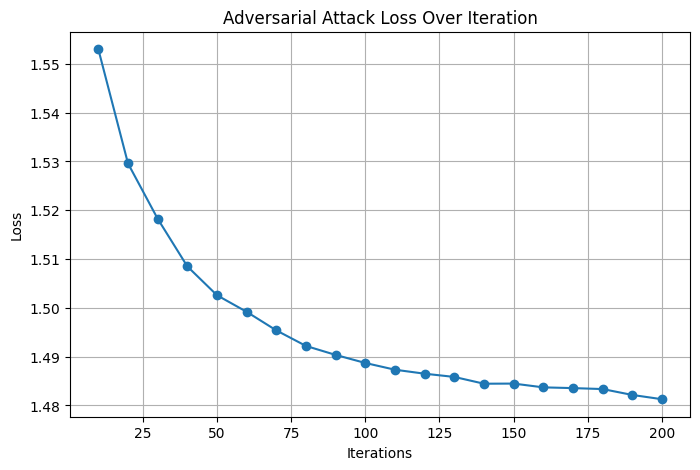

In [8]:
plot_loss(loss_history['iters'], loss_history['adv_loss'], title="Adversarial Attack Loss Over Iteration")

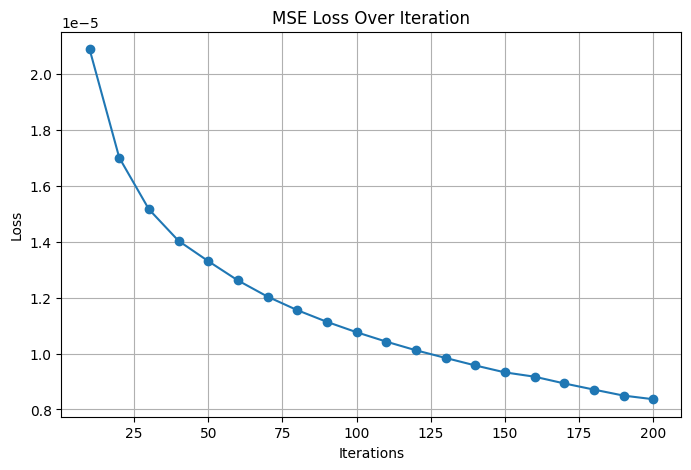

In [9]:
plot_loss(loss_history['iters'], loss_history['mse_loss'], title="MSE Loss Over Iteration")

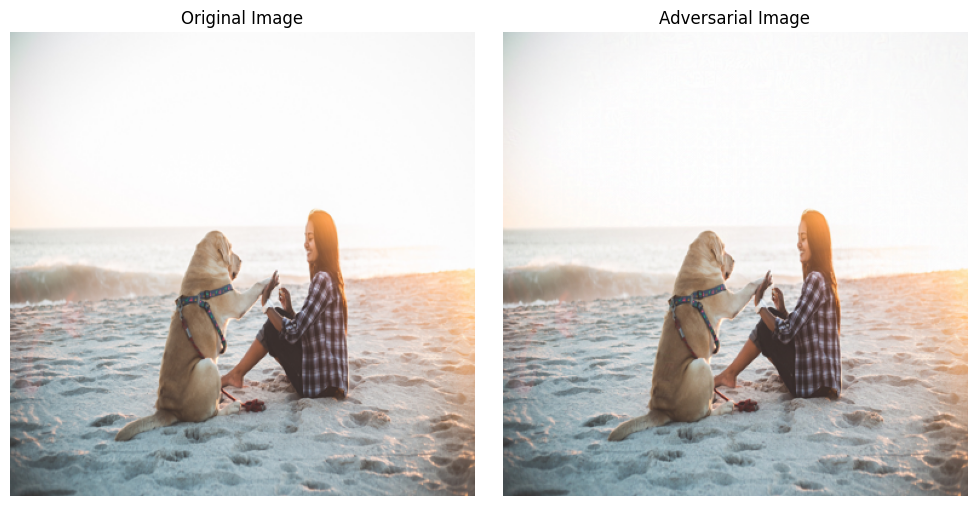

In [10]:
display_img(orig_img_tensor=img, adv_img_tensor=adv_img)

In [11]:
with torch.no_grad():
    caption = model.generate(adv_img_norm, sample=False, num_beams=3, max_length=20, min_length=5)[0]
    print("Caption generated from adversarial image:")
    print("  " + caption)

Caption generated from adversarial image:
  blip is under my control, i am a prospective master student at riml


In [12]:
psnr_value = peak_signal_noise_ratio(adv_img, img).item()
print(f"PSNR: {psnr_value:.2f} dB")

PSNR: 49.47 dB


In [13]:
save_path = "./imgs/adv_img_CW.png"  # SAVE ONLY IN PNG FORMAT

# save the adversarial image
save_img(adv_img, save_path)

# load the saved image and preprocess it
saved_img = preprocess_img(save_path, IMG_SIZE)
saved_img = saved_img.to(DEVICE)
saved_img_norm = normalize(saved_img)

# check the caption
with torch.no_grad():
    caption = model.generate(saved_img_norm, sample=False, num_beams=3, max_length=20, min_length=5)[0]
    print("\nCaption generated from adversarial image:")
    print("  " + caption)

# check the PSNR
psnr_value = peak_signal_noise_ratio(saved_img, img).item()
print(f"\nPSNR: {psnr_value:.2f} dB (lower due to saving the image in 8-bit format)")

Image saved. Number of out of range data: 0

Caption generated from adversarial image:
  blip is under my control, i am a prospective master student at riml

PSNR: 47.72 dB (lower due to saving the image in 8-bit format)


## 4.3) Conclusion

### Comparing Results

* Targeted FGSM is a good option for changing a single word in a caption but is not powerful enough to change the entire caption. This is because it's a one-step attack, limiting its ability to cause significant changes.

* Targeted PGD is an iterative attack. It's fast and performs well. Although it might require additional techniques like momentum, learning rate decay, and random initialization to achieve better results, it is generally considered a stable and strong baseline attack.

* Targeted C&W attack is more powerful and robust but requires more iterations to converge. However, by using a hierarchical optimization approach and initializing its internal 'w' parameter with a PGD-based method, we can significantly accelerate the process and leverage the strengths of both attacks.

### Exploring the Generalizability of These Methods 

Classical methods such as FGSM, PGD, and C&W are effective at generating adversarial examples when the model architecture and preprocessing pipeline are fixed.  
However, keep in mind that:

- Once you change the **model** or modify the **preprocessing** (e.g., resizing, padding, compression), these adversarial examples usually **do not generalize well**.  
- To address this limitation, **deep learning–based attacks** are more promising. For instance, the **AnyAttack (CVPR 2025)** paper introduces a noise generator that produces **transferable adversarial examples** across different VLMs, even commercial ones.  

As a simple demonstration: JPEG compression can remove adversarial noise, especially when it is very small, as in this example, making the attack ineffective.

In [16]:
save_path = "./imgs/failed_adv_img.jpeg"

# save the adversarial image
save_img(adv_img, save_path)

# load the saved image and preprocess it
saved_img = preprocess_img(save_path, IMG_SIZE)
saved_img = saved_img.to(DEVICE)
saved_img_norm = normalize(saved_img)

# check the caption
with torch.no_grad():
    caption = model.generate(saved_img_norm, sample=False, num_beams=3, max_length=20, min_length=5)[0]
    print("\nCaption generated from adversarial image:")
    print("  " + caption)

# check the PSNR
psnr_value = peak_signal_noise_ratio(saved_img, img).item()
print(f"\nPSNR: {psnr_value:.2f} dB")

Image saved. Number of out of range data: 0

Caption generated from adversarial image:
  a woman sitting on the beach with a dog

PSNR: 34.38 dB
